### Import Lib

In [1]:
import numpy as np
import pandas as pd 
import os
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

#for visualization
import matplotlib.pyplot as plt
from PIL import  Image
%matplotlib inline
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.subplots as tls
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [2]:
#Read Data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


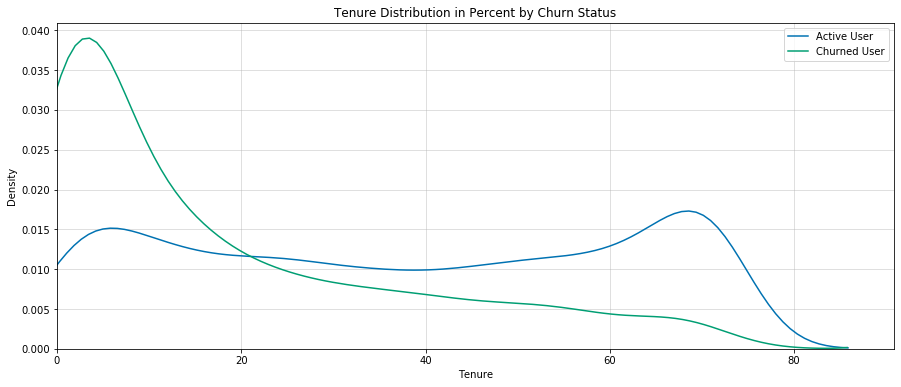

In [3]:
#To See the Tenure Distribution of active and churned User
plt.figure(figsize=(15,6))
plt.style.use('seaborn-colorblind')
plt.grid(True, alpha=0.5)
sns.kdeplot(df.loc[df['Churn'] == 'No', 'tenure'], label = 'Active User')
sns.kdeplot(df.loc[df['Churn'] == 'Yes', 'tenure'], label = 'Churned User')
plt.xlabel('Tenure')
plt.xlim(left=0)
plt.ylabel('Density')
plt.title('Tenure Distribution in Percent by Churn Status');

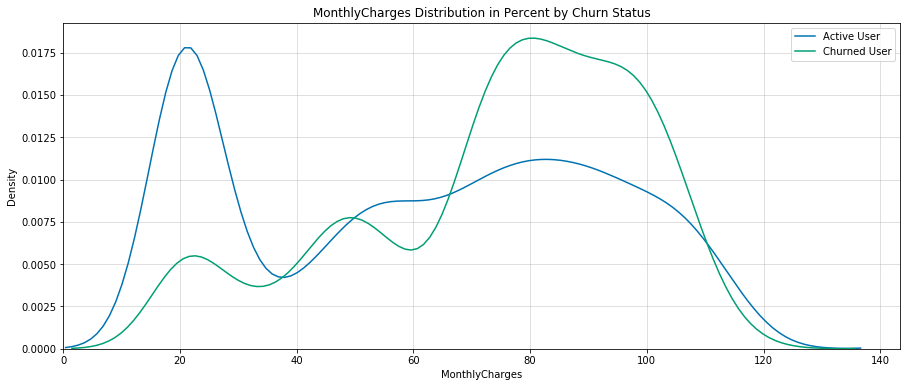

In [4]:
#To See the Monthy Charges Distribution of active and churned User
plt.figure(figsize=(15,6))
plt.style.use('seaborn-colorblind')
plt.grid(True, alpha=0.5)
sns.kdeplot(df.loc[df['Churn'] == 'No', 'MonthlyCharges'], label = 'Active User')
sns.kdeplot(df.loc[df['Churn'] == 'Yes', 'MonthlyCharges'], label = 'Churned User')
plt.xlabel('MonthlyCharges')
plt.xlim(left=0)
plt.ylabel('Density')
plt.title('MonthlyCharges Distribution in Percent by Churn Status');

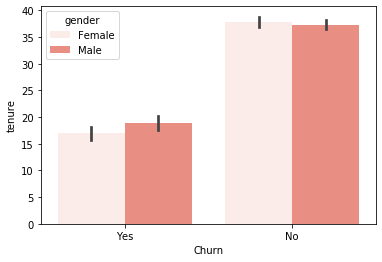

In [60]:
#To Observe 3 Attribute which is gender,churn and tenure
sns.barplot(x="Churn",y="tenure",hue="gender", data=df,color="salmon",order=["Yes", "No"])

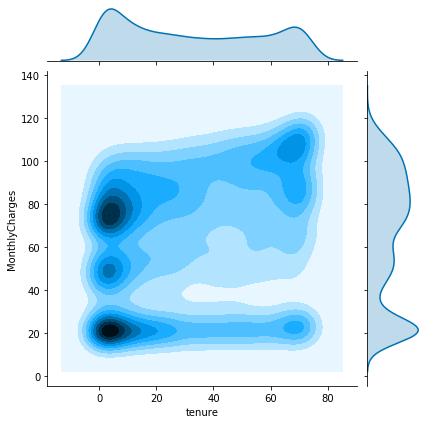

In [81]:
#To Observe KDE of Tenure Against Monthly Charges
sns.jointplot(x="tenure", y="MonthlyCharges", data=df,kind="kde");

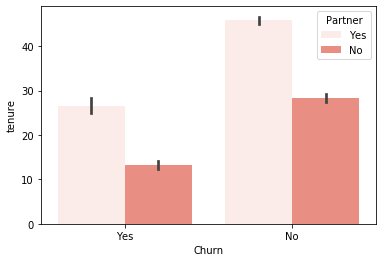

In [43]:
#To Observe 3 Attribute which is have partners?,churn and tenure
sns.barplot(x="Churn", y="tenure",hue="Partner", data=df,color="salmon",order=["Yes", "No"],hue_order=["Yes", "No"])

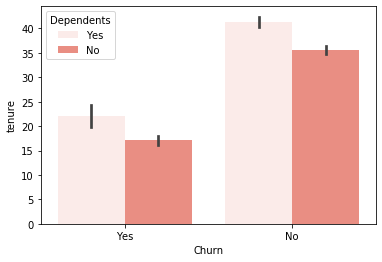

In [47]:
#To Observe 3 Attribute which is have dependents?,churn and tenure
sns.barplot(x="Churn", y="tenure",hue="Dependents", data=df,color="salmon",order=["Yes", "No"],hue_order=["Yes", "No"])

In [82]:
#Data Manupilation
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)
df = df[df["TotalCharges"].notnull()]
df =df.reset_index()[df.columns]
df['TotalCharges']= df['TotalCharges'].astype(float)

replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    df[i]  = df[i].replace({'No internet service' : 'No'})

    
df["SeniorCitizen"] = df["SeniorCitizen"].replace({1:"Yes",0:"No"})

def tenure_lab(df) :
    
    if df["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (df["tenure"] > 12) & (df["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (df["tenure"] > 24) & (df["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (df["tenure"] > 48) & (df["tenure"] <= 60) :
        return "Tenure_48-60"
    elif df["tenure"] > 60 :
        return "Tenure_gt_60"
df["tenure_group"] = df.apply(lambda df:tenure_lab(df),
                                      axis = 1)

churn     = df[df["Churn"] == "Yes"]
not_churn = df[df["Churn"] == "No"]


In [83]:
Id_col     = ['customerID']
target_col = ["Churn"]
cat_cols   = df.nunique()[df.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in df.columns if x not in cat_cols + target_col + Id_col]

In [84]:
val= df["Churn"].value_counts().values.tolist()
lab= df["Churn"].value_counts().keys().tolist()

In [85]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#customer id col
Id_col     = ['customerID']
#Target columns
target_col = ["Churn"]
#categorical columns
cat_cols   = df.nunique()[df.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in df.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = df.nunique()[df.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

In [86]:
### Preprocessing

le = LabelEncoder()
for i in bin_cols :
    df[i] = le.fit_transform(df[i])
    
#Duplicating columns for multi value columns
df = pd.get_dummies(data = df,columns = multi_cols )
std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_telcom_og = df.copy()
df = df.drop(columns = num_cols,axis = 1)
df = df.merge(scaled,left_index=True,right_index=True,how = "left")

In [100]:
print(churn.columns)
multi_cols

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'tenure_group'],
      dtype='object')


['MultipleLines',
 'InternetService',
 'Contract',
 'PaymentMethod',
 'tenure_group']

In [ ]:
trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'purple' ,'pink'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 0,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Customer attrition in data (Total Customer From Database)",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

In [ ]:
#FX for PIe Chart
def plot_pie(column) :
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2,color = "rgb(243,243,243)")),
                    hole    = .6)
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,color = "rgb(243,243,243)")),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Stayyed customers" 
                   )

    layout = go.Layout(dict(title = column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",font = dict(size = 13),showarrow = False,
                                                x = .15, y = .5),dict(text = "Stayyed customers",font = dict(size = 13),showarrow = False,
                                                x = .88,y = .5)]))
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)

In [ ]:
#FX for Histo Graph
def histogram(column) :
    trace1 = go.Histogram(x  = churn[column],
                          histnorm= "percent",
                          name = "Churn Customers",
                          marker = dict(line = dict(width = .5,color = "black")),
                         opacity = .9) 
    
    trace2 = go.Histogram(x  = not_churn[column],
                          histnorm = "percent",
                          name = "Stayyed customers",
                          marker = dict(line = dict(width = .5,color = "black")),opacity = .9)
    
    data = [trace1,trace2]
    layout = go.Layout(dict(title =column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2),))
    fig  = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)

In [ ]:
#FX for scatter plot
def scatter_matrix(df)  :
    
    df  = df.sort_values(by = "Churn" ,ascending = True)
    classes = df["Churn"].unique().tolist()
    classes
    
    class_code  = {classes[k] : k for k in range(2)}
    class_code

    color_vals = [class_code[cl] for cl in df["Churn"]]
    color_vals

    pl_colorscale = "Portland"

    pl_colorscale

    text = [df.loc[k,"Churn"] for k in range(len(df))]
    text

    trace = go.Splom(dimensions = [dict(label  = "tenure",
                                       values = df["tenure"]),
                                  dict(label  = 'MonthlyCharges',
                                       values = df['MonthlyCharges']),
                                  dict(label  = 'TotalCharges',
                                       values = df['TotalCharges'])],
                     text = text,
                     marker = dict(color = color_vals,
                                   colorscale = pl_colorscale,
                                   size = 3,
                                   showscale = False,
                                   line = dict(width = .1,
                                               color='rgb(230,230,230)'
                                              )
                                  )
                    )
    axis = dict(showline  = True,
                zeroline  = False,
                gridcolor = "#fff",
                ticklen   = 4
               )
    
    layout = go.Layout(dict(title  = 
                            "Scatter plot matrix for Numerical columns for customer attrition",
                            autosize = False,
                            height = 800,
                            width  = 800,
                            dragmode = "select",
                            hovermode = "closest",
                            plot_bgcolor  = 'rgba(240,240,240, 0.95)',
                            xaxis1 = dict(axis),
                            yaxis1 = dict(axis),
                            xaxis2 = dict(axis),
                            yaxis2 = dict(axis),
                            xaxis3 = dict(axis),
                            yaxis3 = dict(axis),
                           )
                      )
    data   = [trace]
    fig = go.Figure(data = data,layout = layout )
    py.iplot(fig)

In [ ]:
#for all categorical columns plot pie
for i in cat_cols :
    plot_pie(i)

#for all categorical columns plot histogram    
for i in num_cols :
    histogram(i)

#scatter plot matrix
scatter_matrix(df)

In [ ]:
churn['gender'].value_counts().values.tolist()

In [ ]:
df.hist(figsize=(20,20))
plt.show()

In [ ]:
df['gender'].value_counts()

In [ ]:
#Correlation HeatMap

corr = df.corr()
matrix_cols = corr.columns.tolist()
corr_array  = np.array(corr)

trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data = [trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)


In [97]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_Tenure_0-12,tenure_group_Tenure_12-24,tenure_group_Tenure_24-48,tenure_group_Tenure_48-60,tenure_group_Tenure_gt_60,tenure,MonthlyCharges,TotalCharges
0,7590-VHVEG,0,0,1,0,0,0,1,0,0,...,1,0,1,0,0,0,0,-1.280248,-1.161694,-0.994194
1,5575-GNVDE,1,0,0,0,1,1,0,1,0,...,0,1,0,0,1,0,0,0.064303,-0.260878,-0.173740
2,3668-QPYBK,1,0,0,0,1,1,1,0,0,...,0,1,1,0,0,0,0,-1.239504,-0.363923,-0.959649
3,7795-CFOCW,1,0,0,0,0,1,0,1,1,...,0,0,0,0,1,0,0,0.512486,-0.747850,-0.195248
4,9237-HQITU,0,0,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,-1.239504,0.196178,-0.940457


In [13]:
print(df['MonthlyCharges'])

0        29.85
1        56.95
2        53.85
3        42.30
4        70.70
         ...  
7038     84.80
7039    103.20
7040     29.60
7041     74.40
7042    105.65
Name: MonthlyCharges, Length: 7043, dtype: float64
